# Libraries

In [26]:
## libraries
import sys
import os
import pandas as pd
import seaborn as sns
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
import numpy as np

%matplotlib inline

# to import Database class from data_collection folder
module_path = os.path.abspath(os.path.join('..')+'/data_collection')
if module_path not in sys.path:
    sys.path.append(module_path)

# now that the folder is in the path, ../data_collection/database.py can be imported
from database import Database

# Data Collection Summary:

- Yelp API search yieleded 4098 halal-related restaurants in NYC
- 5092 reviews containinf the word Halal were found in those restaurants
- In particular, 838 of those restaurants had reveiws that contained the word Halal


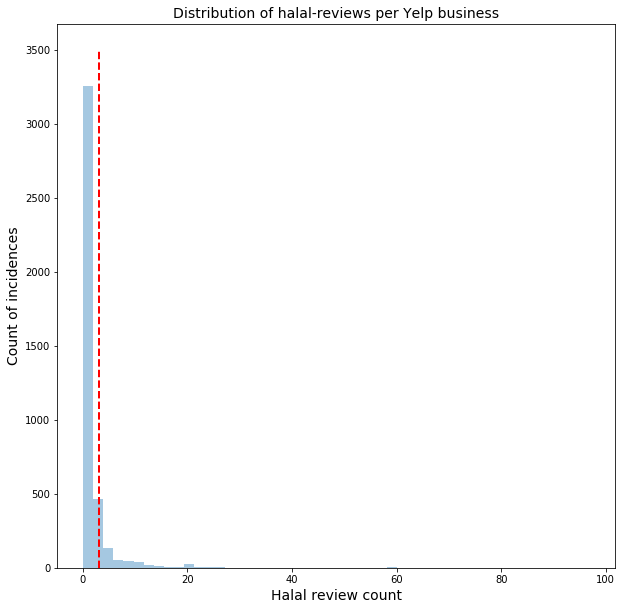

In [2]:
db = Database()

# get yelp businesses
yelp_sql = '''SELECT * FROM businesses WHERE url LIKE '%yelp%' '''
yelp_df = db.select_df(yelp_sql)
print('\033[1m- Yelp API search yieleded {} halal-related restaurants in NYC'.format(yelp_df.shape[0]))

# get halal-reviews (reviews that include the word 'halal')
reviews_sql = '''SELECT * FROM reviews'''
reviews_df = db.select_df(reviews_sql)
print('- {} reviews containinf the word Halal were found in those restaurants'.format(reviews_df.shape[0]))

# subset of yelp businesses with halal-reviews
halal_yelp_df = yelp_df[ yelp_df.platform_id.isin(reviews_df.restaurant_id.unique())]
print('- In particular, {} of those restaurants had reveiws that contained the word Halal\033[0m'.format(halal_yelp_df.shape[0]))


# add column with num of scraped reviews per business
counts = reviews_df.restaurant_id.value_counts()
yelp_df = yelp_df.assign(halal_review_count=yelp_df.platform_id.map(dict(zip(counts.index, counts.values))))
yelp_df.halal_review_count = yelp_df.halal_review_count.fillna(0)

# plot histogram of counts per restaurant
plt.figure(figsize=(10,10))
g = sns.distplot(yelp_df.halal_review_count, kde = False)
g.set_title('Distribution of halal-reviews per Yelp business', size=14)
g.set_xlabel('Halal review count', size=14)
g.set_ylabel('Count of incidences', size=14)
plt.plot([3, 3],[0, 3500], linewidth=2, linestyle='dashed', color='r') # cutoff between 2 & 5. To remove noise
plt.show()

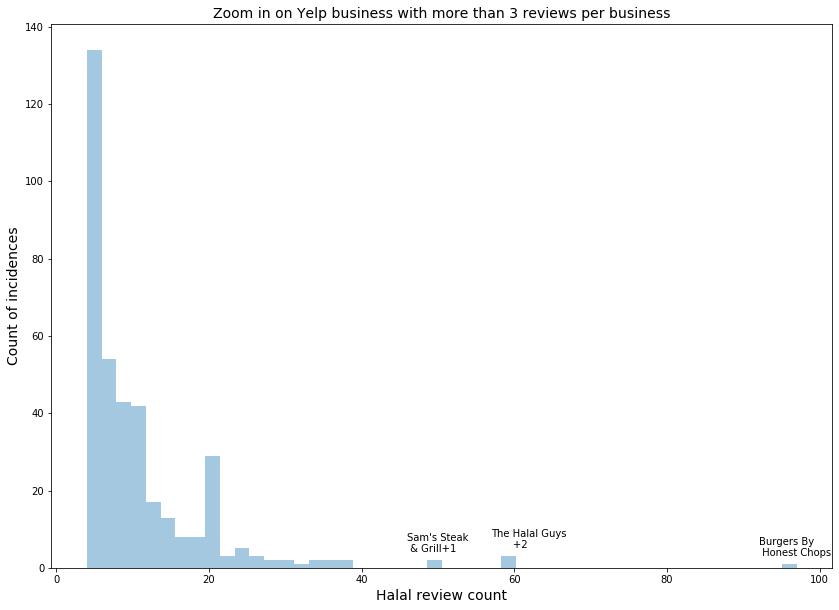

In [3]:
# plot histogram of Yelp businesses with more than 10 halal-reviews
fig, ax = plt.subplots(figsize=(14,10))
g = sns.distplot(yelp_df.halal_review_count[yelp_df.halal_review_count>3], kde = False, ax=ax)
g.set_title('Zoom in on Yelp business with more than 3 reviews per business', size=14)
g.set_xlabel('Halal review count', size=14)
g.set_ylabel('Count of incidences', size=14)

# Add labels to the plot
style = dict(size=10)
ax.text(92, 3, 'Burgers By\n Honest Chops', **style)
ax.text(57, 5, 'The Halal Guys\n       +2', **style)
ax.text(46, 4, "Sam's Steak\n & Grill+1", **style)
plt.show()

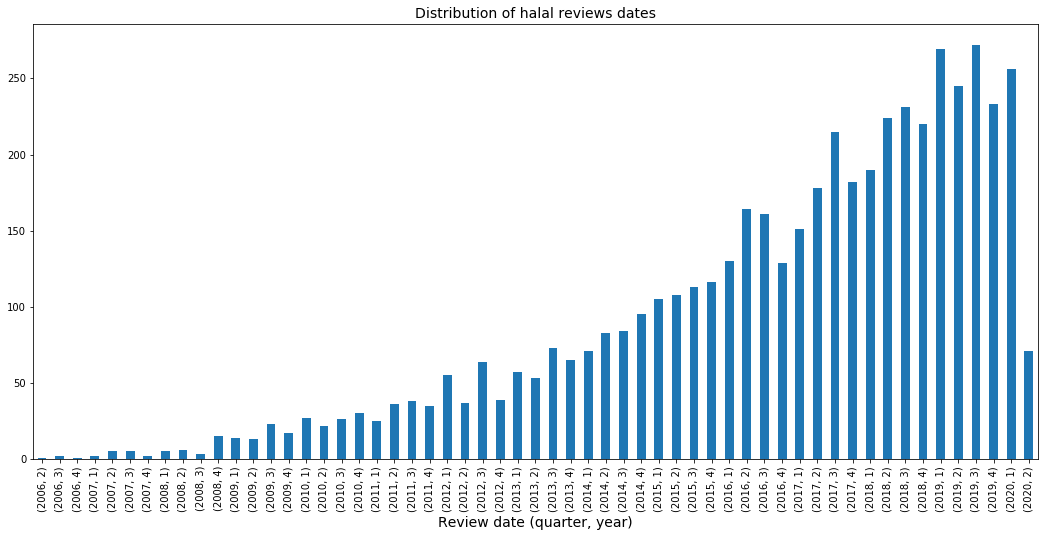

In [4]:
# distribution of reviews' dates
reviews_df.review_date[0]
# df["date"] = df["date"].astype("datetime64")
# df.groupby(df["date"].dt.month).count().plot(kind="bar")
ax, fig = plt.subplots(figsize=(18,8))
reviews_df.review_date = reviews_df['review_date'].astype('datetime64')
reviews_df.groupby([reviews_df.review_date.dt.year, reviews_df.review_date.dt.quarter])['id'].count().plot(kind='bar')
plt.title('Distribution of halal reviews dates', size=14)
plt.xlabel('Review date (quarter, year)', size=14)
plt.show()

# Target Feature 
## Halal restaurants from Zabiha.com & Zomato.com

- 745 Halal-confirmed restaurants were found on Zabiha.com
- 340 Halal-tagged restaurants were found on Zomato.com


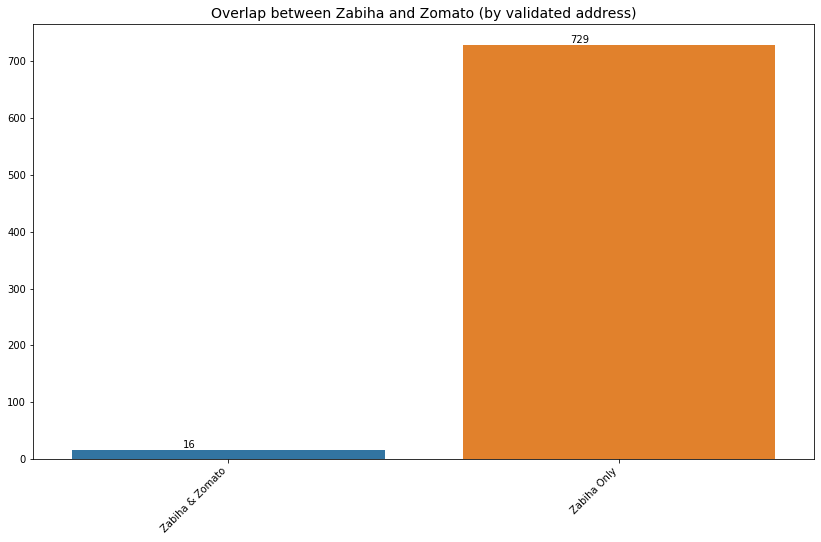

In [5]:
target_df = pd.read_csv('/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/data/data_collection/target_list.csv', index_col=0)
print('\033[1m- {} Halal-confirmed restaurants were found on Zabiha.com'.format(sum(target_df['source'] == 'Zabiha'))) # 745 restaurants from Zabiha.com
print('- {} Halal-tagged restaurants were found on Zomato.com\033[0m'.format(sum(target_df['source'] == 'Zomato'))) # 340 restaurants from Zomato.com

target_df['validated_address'] = target_df['validated_address'].str.lower()
target_match = target_df['validated_address'][target_df.source == 'Zabiha'].isin(target_df['validated_address'][target_df.source == 'Zomato'])
target_match_count = [sum(target_match), len(target_match)-sum(target_match)]

plt.figure(figsize=(14,8))
g = sns.barplot(x=['Zabiha & Zomato','Zabiha Only'], y=target_match_count)
g.set_title('Overlap between Zabiha and Zomato (by validated address)', size=14)
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                ha='center', va='bottom', color= 'black')

## Is this because of the address validation? What if we comapre by name?

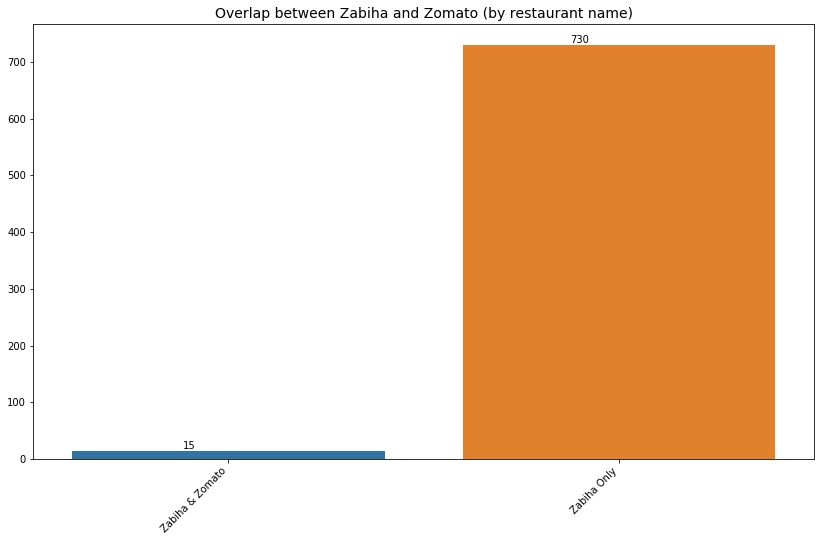

In [6]:
plt.figure(figsize=(14,8))
target_df['name'] = target_df['name'].str.lower()
target_match = target_df['name'][target_df.source == 'Zabiha'].isin(target_df['name'][target_df.source == 'Zomato'])
target_match_count = [sum(target_match), len(target_match)-sum(target_match)]
g = sns.barplot(x=['Zabiha & Zomato','Zabiha Only'], y=target_match_count)
g.set_title('Overlap between Zabiha and Zomato (by restaurant name)', size=14)
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                ha='center', va='bottom', color= 'black')

## How many Yelp restaurants (838) with halal reviews match halal-confirmed restaurants (745) from Zabiha.com?

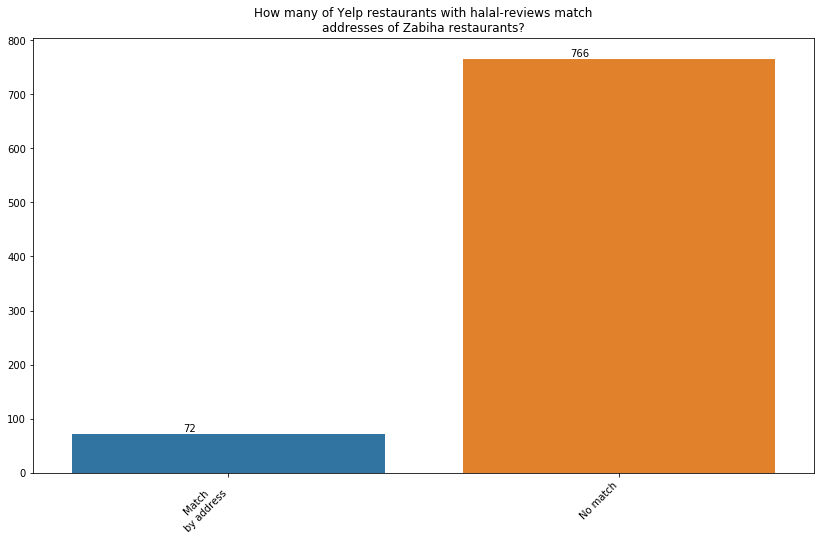

In [7]:
# cleanup yelp address to match validated addresses
yelp_df.address = yelp_df.address.str.lower()
yelp_df.address = yelp_df.address.map(lambda address: re.sub(r'[^A-Za-z0-9, ]+', '', address).split(','))
yelp_df.address = yelp_df.address.map(lambda address: ', '.join([str.strip() for str in address])+', usa')

# only yelp businesses with halal reviews
halal_mask = yelp_df['platform_id'].isin(reviews_df['restaurant_id'].unique())
halal_df = yelp_df[halal_mask]

# only Zabiha results
zabiha_df = target_df[ target_df.source == 'Zabiha']

# overlap with Zabiha.com by address
address_match = halal_df['address'].isin(zabiha_df['validated_address'])
address_match_count = [sum(address_match), len(address_match)-sum(address_match)]

plt.figure(figsize=(14,8))
g = sns.barplot(x=['Match    \nby address','No match'], y=address_match_count)
g.set_title('How many of Yelp restaurants with halal-reviews match\naddresses of Zabiha restaurants?')
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                ha='center', va='bottom', color= 'black')

## How about Yelp restaurants (838) with halal reviews that match halal-confirmed restaurants (340) from Zomato.com?

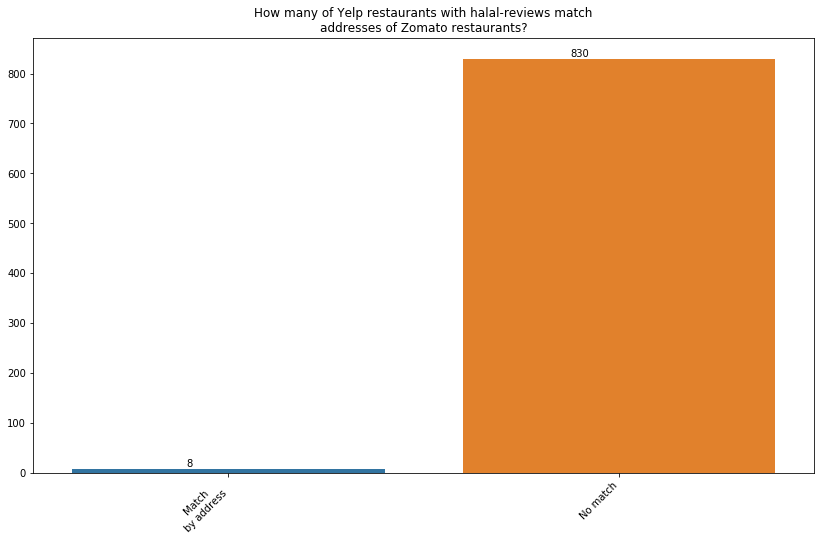

In [8]:
# only Zabiha results
zomato_df = target_df[ target_df.source == 'Zomato']
# overlap with Zabiha.com by address
address_match = halal_df['address'].isin(zomato_df['validated_address'])
address_match_count = [sum(address_match), len(address_match)-sum(address_match)]

plt.figure(figsize=(14,8))
g = sns.barplot(x=['Match    \nby address','No match'], y=address_match_count)
g.set_title('How many of Yelp restaurants with halal-reviews match\naddresses of Zomato restaurants?')
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                ha='center', va='bottom', color= 'black')

## Do the Zabiha list match any restaurants that don't have halal-reviews?

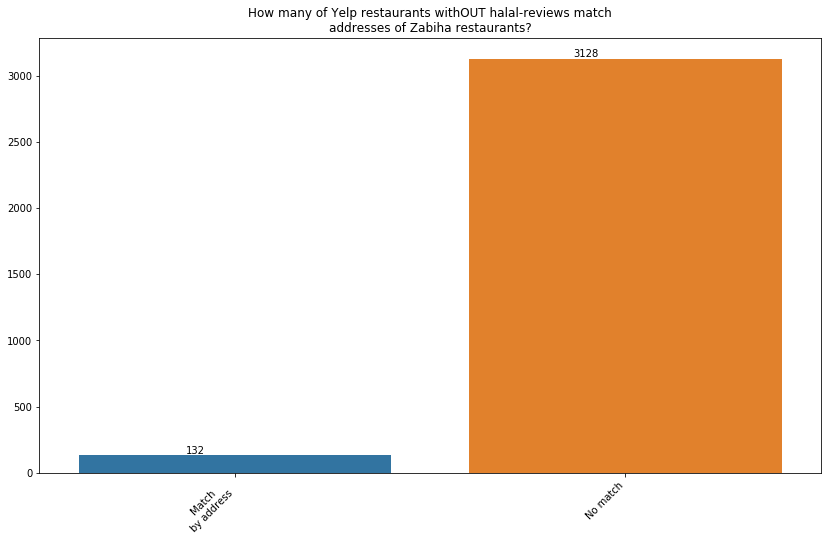

In [9]:
# only yelp businesses withOUT halal reviews
not_halal_mask = yelp_df['platform_id'].isin(reviews_df['restaurant_id'].unique())
not_halal_df = yelp_df[~not_halal_mask]

# overlap with Zabiha.com by address
address_match = not_halal_df['address'].isin(zabiha_df['validated_address'])
address_match_count = [sum(address_match), len(address_match)-sum(address_match)]

plt.figure(figsize=(14,8))
g = sns.barplot(x=['Match    \nby address','No match'], y=address_match_count)
g.set_title('How many of Yelp restaurants withOUT halal-reviews match\naddresses of Zabiha restaurants?')
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                ha='center', va='bottom', color= 'black')

In [34]:
for i, row in yelp_df.iterrows():
    print(row['name'])

Peri Peri Grill House
MashAllah Grill & Restaurant
Gyro Mania
Middle Eastern Halal Food
Black Nile
Best Halal Gyro & Grill
Zaiqa Halal Food
BK JANI
Halal Xpress
The Halal Spot
Burger Box
Twisted Wings
Halal Cart At Flushing and Broadway
Crepe Factory
Memo Shish Kebab - Brooklyn
Ruzana
Main House BBQ
David's Brisket House and Deli
Karam Restaurant
Jay's Quick Bites
Joloff Restaurant
Canarsie Chicken & Gyro
First Oasis
Zatar
Mashallah Grill and Chaat House
Flame Gyro
Yummy Yummy In My Tummy
Mama Kitchen
Holy Cow
Bakhter Halal Food
Abir Halal Restaurant
Kabob Shack
No Pork Halal Kitchen
Black Iris
Ali's Trinidad Roti Shop
Williamsburg Halal Food
Halal Paradise
Dar 525
Halal West Indian and American Cuisine
Pita Gyro And Grill
212 Burgers
Mayfield
Namaste
Mandela Halal Buffet
Hong Kong Cafe
Crown Halal Chicken and Pizza
Meat Cafe
Diwan Grill Indian Cuisine
Kazi Halal
Zyara NY
Brooklyn Burgers & Beer
Jasim's #1 Gourmet Deli
Grand Sultan
Gyro & BBQ
My House Burgers & Shakes
Dagan Grille
Huna

Adel's Famous Halal Food
Big Boss Halal Food
Halal Kitchen
United Halal Food
Omar's Mediterranean East Midtown
Royal Grill Halal Food
Twisted Mexican Grill
The Casbah - Halal Cart
Afghan Kebab House II
Egyptian Halal Food
Ravagh Persian Grill
Empire Halal Kabab & Grill
Terry and Yaki
Ganesh Temple Canteen
Daro's Pizza & Chicken
Elite Kosher Restaurant
John's Little Food Cart
Golden Palace Gourmet
Zaiqa Restaurant
Lazzat Restaurant
Liu's Shanghai
Affy's Premium Grill
Istanbul Bay
Texas Chicken & Burgers
Istanbul Turkish Cafe
Taci's Beyti
Cafe Kashkar
Halal Cart
4 Brothers Halal Cart
grill n dine
Harway Pizza Gyro Falafel
China Pagoda
L & B Spumoni Gardens
Grill Point - Brooklyn
King Souvlaki
Bab Alhara
My House Burgers & Shakes
Lavash
Gyro Cafe
Kings Gourmet Food
Middle Eastern Halal Food
Indian Food & Falafel
Lagman House
Hazar Turkish Kebab
Halal 'Frito Lay' Truck
Fefo Food
Babu Ji
S'MAC
Sahadi's
The Odeon
Istanbul Park
New York Fried Chicken
Vaibhav Indian Spice Journey
5th Avenue Ma

Ravagh Persian Grill
LoveMama
Sam's Falafel Stand
Sultan Restaurant & Cafe Lounge
Desi Cuisine
Meze
Taboonette
Momo's Mediterranean Grill
28th & Madison Halal Stand
Upi Jaya
Avenue BBQ Hut
Greek Pie Factory
Halal Munchies
Habiba B&B Halal
AwesomeSauce
Mahmoud's Corner
Thai Nara Halal Restaurant
The Halal Guys
Halal Sandwich Shop
King of Falafel & Shawarma - Restaurant
Fatima's Halal Kitchen
Little Morocco
Zyara Restaurant
Tikka Grill
King of Falafel & Shawarma - Truck
Truva Cafe and Grill
Lido Kosher Deli
Mr. Deli & Grill
Choban Farm Market
Tarboosh
The Kati Roll Company
Khyber Pass
Moustache
Fatoosh Pitza & Grill
Blue Ribbon Fried Chicken - East Village
Gold Street Market
GupShup
Rumi Turkish Grill
Cafe 11
Sunny and Annie's
Ambizza Cafe Food Truck
Awash Ethiopian Restaurant
Lahori Kabab Restaurant
Nanoosh
Balade Your Way
Taco Morelos
Indian Bollywood Drama
Cafe Himalaya
Williamsburg Smorgasburg - Saturday
Simit Sarayi
Salt & Pepper
Shanghai Dumpling
Pita Grill
Olympia Pita
Aksaray Tur

Village Crown Kosher Catering
Dos Toros Taqueria
Urbanspace
Stamina Grill & Juice Bar
Habibi Mediterranean And Texmex Grill
Gee Mart
The Halal Guys
Kabob Guys
Lebanese Bistro
Fares Arabic Cuisine
Universal Market & Indian Restaurant
Dimassi's Mediterranean Buffet
Essen Fast Slow Food
Westside Restaurant
Sombrero Cart
NY Brat Factory
Starbucks
Taco Today
Artichoke Basille's Pizza
Doner and Gyros
The Meat Cellar
Upland Kabob
Darvish Restaurant
Bali Indonesian Cuisine
Ali Baba Hookah Lounge
Falafelo House
Aljibani Halal Market
Al Amir Bakery
Giuseppe's Restaurant
Zaky Mediterranean Grill
Swad Of India
Boca Burger
Dolce Bistro & Bakery
Aria Kabob And Bar
Freshway Marketplace
Curry Up
The Grill House
Sunrise Donut & Burger
Super King Markets
Cafe Fresco
Gyro Cart
Del Frisco's Double Eagle Steakhouse
Pio Pio 8
Desi Deli Indian Restaurant
Cosme
LAVO
99 Cents Fresh Pizza and Deli
Perry St
Cafe 53
Pilar Cuban Eatery
Milk 'N Honey NYC
Zam Zam
Talia's Steakhouse & Bar
The Prince Deli Grocery
Manh

Villa Restaurant & Lounge
Himalayan Yak
Potala Restaurant
Dosa Delight
Mom's Momo
Abdullah Sweets and Restaurant
Starbucks
Macoletta
Prince Kabab & Chinese Restaurant
Spicy Shallot
Mr Wonton
Afghan boys
Kennedy Chicken
Shan Halal Meat & Grocery
PappaRich Flushing
Hahm Ji Bach
Kennedy Fried Chicken
The Buffet
Silk Hookah Lounge & Grill
Kennedy Chicken Pizza & Kabab
Pio Pio 2
Bake Culture
Yummy Fried Chicken & Pizza
Coco Fresh Tea & Juice
PokéWave
Caffe Bene
Texas Chicken & Burgers
Carlos & Gabby's Riverdale
Pizza Block
Top Tomato
Bred's Nashville Hot Chicken
Ribs N Kabobs
YoYo Burgers and Chicken
Burger Boss
Crepes Maison
The Halal Guys
Krispy Krunchy Chicken - Halal Food
Quick Halal Gyro and Kebab
Fire Stone Grill and Pizza
WOW Halal food
Chicky’s
The Halal Bros of NY
LI's Halal Food
Wok & Grill
Al Nawaab
King’s Halal
Curry on Pizza
Lucky food cart
Kennedy Fried Chicken
Jabar Famous Deli
Sweeterman's Pastries
Bismillah Halal Meat and Grocery
Crown Fried Chicken
Catfish Cafe
KFC
Crown F

Pâté
White Castle
Tarim Uyghur Food
Steve's Deli & Grill
Singh's Roti Shop & Bar
Mizumi
Golden Punjab
Taco King
88 Canteen
Linden Superette
Dunkin'
Melody Glatt Kosher
Bodai Vegetarian
Olive Mediterranean Grill
Karachi Chat House
Pizza Ready
Indian Clay Pot
TAVA Fresh Taste of India
IDOF Fresh Mediterranean
Naansense
Rice'N Bread
L. Woods Tap & Pine Lodge
Pakeeza Restaurant
Sankalp Restaurant
Cheesie's Pub & Grub
Delhi Darbar Kabab House
Luzzat
IDOF Fresh Mediterranean
Aroma Fine Indian Cuisine
Johnny's Beef & Gyros - Lincoln Park
Papas Philly
Bahama Breeze
Atino's Pizza
Larsa's Mediterranean
Baba's Village
Xoco
Thrupthi Foods
Roka Akor - Chicago
Naf Naf Grill
Hfc halal fried chicken and seafood
Good Morgan Cafe
Chicago Zabiha Halal Meat Market
RPM Steak
Cafe Ba-Ba-Reeba!
Americana Submarine
Friends Ramen
Pete's Fresh Market
Francesca's Bryn Mawr
Sahar International Supermarket
Valli Produce
Bawarchi on Devon Restaurant
Bang Bang Pie & Biscuits
Giordano's
Sariling Atin Filipino Restaur

In [36]:
yelp_df

,name,platform_id,url,total_review_count,address,id,halal_review_count
0,Peri Peri Grill House,KPGZ6zr6lUX9YROjGcUbtw,https://www.yelp.com/biz/peri-peri-grill-house...,146.0,"235 malcolm x blvd, brooklyn, ny 11233, usa",5178,9.0
1,MashAllah Grill & Restaurant,xh6w5exbzfUWrZXGz09OUg,https://www.yelp.com/biz/mashallah-grill-and-r...,1.0,"2368 flatbush ave, brooklyn, ny 11234, usa",5179,0.0
2,Gyro Mania,ctVgx_mIwt2Fwc48Pgjhlw,https://www.yelp.com/biz/gyro-mania-bath-beach...,41.0,"2151 bath ave, bath beach, ny 11214, usa",5180,9.0
3,Middle Eastern Halal Food,WekK6vHrQZ-81CijH2sGiw,https://www.yelp.com/biz/middle-eastern-halal-...,146.0,"8601 5th ave, brooklyn, ny 11209, usa",5182,20.0
4,Black Nile,IPh4H0AfWk5LVplgYV9OGQ,https://www.yelp.com/biz/black-nile-brooklyn-2...,176.0,"592 nostrand ave, brooklyn, ny 11216, usa",5181,0.0
...,...,...,...,...,...,...,...
4093,A Taste of the Caribbean,CD7o3dgK8XC-hE1rUQ0b3A,https://www.yelp.com/biz/a-taste-of-the-caribb...,1.0,"3117 n sharon amity rd, charlotte, nc 28205, usa",29221,0.0
4094,Chex Grill & Wings,uW-17lZoo9rRy4TwcU16iA,https://www.yelp.com/biz/chex-grill-and-wings-...,11.0,"3128 the plaza, charlotte, nc 28205, usa",29222,0.0
4095,Dubai Halal Market,7PdZ07fRwtSg-PT6icbPMQ,https://www.yelp.com/biz/dubai-halal-market-ch...,1.0,"1001 e wt harris blvd, ste p, charlotte, nc 28...",29223,0.0
4096,Zaytuna Halal Market,kYoU9542KJRoenNIAH-QuQ,https://www.yelp.com/biz/zaytuna-halal-market-...,3.0,"10227 university city blvd, charlotte, nc 2821...",29224,0.0
